# Simulating an Lennard Jones fluid in OpenMM

## Preliminaries

First, we import OpenMM. It's recommended that you always import this way:

In [1]:
from simtk import openmm, unit
from simtk.openmm import app
import numpy as np

In [2]:
# Create a Lennard-Jones fluid
pressure = 1*unit.atmospheres
temperature = 120*unit.kelvin
collision_rate = 5/unit.picoseconds
timestep = 2.5*unit.femtoseconds
from openmmtools.testsystems import LennardJonesFluid
sigma = 3.4*unit.angstrom; epsilon = 0.238 * unit.kilocalories_per_mole
fluid = LennardJonesFluid(sigma=sigma, epsilon=epsilon)
[topology, system, positions] = [fluid.topology, fluid.system, fluid.positions]

In [3]:
# Add a barostat
barostat = openmm.MonteCarloBarostat(pressure, temperature)
system.addForce(barostat)

1

In [4]:
# Create a context
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
context = openmm.Context(system, integrator)
context.setPositions(positions)

# Minimize energy
print('Minimizing energy...')
openmm.LocalEnergyMinimizer.minimize(context)

Minimizing energy...


In [5]:
# Collect data
nsteps = 100 # number of steps per sample
niterations = 500 # number of samples to collect per alchemical state


In [6]:
u = np.zeros(niterations, np.float64)
kT = unit.AVOGADRO_CONSTANT_NA * unit.BOLTZMANN_CONSTANT_kB * integrator.getTemperature()
for iteration in range(niterations):
        # print('iteration  %5d' % (iteration))
        # Run some dynamics
        integrator.step(nsteps)
        # Compute energies at all alchemical states
        u[iteration] = context.getState(getEnergy=True).getPotentialEnergy() / kT

Let´s plot the energy

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

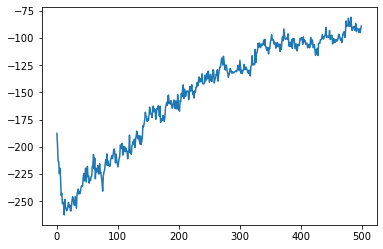

In [8]:
plt.plot(u)

Let´s start a new simulation 

In [9]:
del context, integrator

In [10]:
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
context = openmm.Context(system, integrator)
context.setPositions(positions)

# Minimize energy
print('Minimizing energy...')
openmm.LocalEnergyMinimizer.minimize(context)

Minimizing energy...


In [11]:
# Set velocities from Maxwell-Boltzmann distribution
context.setVelocitiesToTemperature(temperature)

In [12]:
u = np.zeros(niterations, np.float64)
kT = unit.AVOGADRO_CONSTANT_NA * unit.BOLTZMANN_CONSTANT_kB * integrator.getTemperature()
for iteration in range(niterations):
        # print('iteration  %5d' % (iteration))
        # Run some dynamics
        integrator.step(nsteps)
        # Compute energies at all alchemical states
        u[iteration] = context.getState(getEnergy=True).getPotentialEnergy() / kT

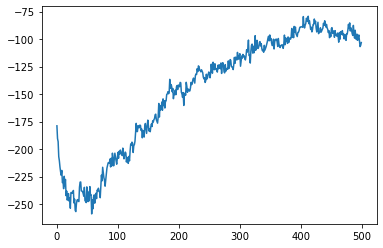

In [13]:
plt.plot(u)

## The `Simulation` convenience class

While we could write our own wrapper to run a simulation and write data to disk, OpenMM's [`app` layer](http://docs.openmm.org/7.1.0/api-python/app.html) provides the [`Simulation` class](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.app.simulation.Simulation.html#simtk.openmm.app.simulation.Simulation) to help you do this using a modular Python-based plugin architecture to specify which and how data should be stored. The [user guide](http://docs.openmm.org/7.1.0/userguide/application.html#a-first-example) provides a nice overview of this.

### Running a `Simulation` that writes data to the terminal

For example, to run a simulation that prints data to the terminal, we can use:

In [14]:
from sys import stdout
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, potentialEnergy=True, temperature=True))
simulation.step(1000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-186.35155552554292,110.76428629086796
200,-192.47534271631528,121.45132722071008
300,-203.05632052285395,116.28342343530939
400,-207.90881649186022,123.17014476740628
500,-212.1704409200524,123.22186086328715
600,-211.79340575002428,121.82343697551995
700,-220.0753890538563,117.73320357083048
800,-218.1226507282132,124.23465204079078
900,-223.324925918093,118.11461152889896
1000,-223.45900545790877,118.11932116846958


### Running a `Simulation` that writes a trajectory to disk

For example, to run a simulation that writes data in the extensible MDTraj HDF5 format, Amber NetCDF format, or CHARMM DCD format, we can use the [MDTraj Reporters](http://mdtraj.org/1.6.2/api/reporters.html):

In [15]:
import mdtraj
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
simulation = app.Simulation(topology, system, integrator)
simulation.context.setPositions(positions)
simulation.minimizeEnergy()
reportInterval = 100
simulation.reporters.append(mdtraj.reporters.HDF5Reporter('output.h5', reportInterval, coordinates=True, time=True, cell=True, potentialEnergy=True, temperature=True))
simulation.reporters.append(mdtraj.reporters.DCDReporter('output.dcd', reportInterval))
simulation.reporters.append(mdtraj.reporters.NetCDFReporter('output.nc', reportInterval))
simulation.step(200000)
del simulation # Make sure to close all files

/Users/evohringer/anaconda/envs/openmmtools/lib/python3.6/site-packages/mdtraj/utils/validation.py:116: TypeCastPerformanceWarning: Casting xyz dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


In [16]:
traj = mdtraj.load('output.h5', 'r')
import nglview
view = nglview.show_mdtraj(traj)
view.add_ball_and_stick('all')
view.center()
view

_ColormakerRegistry()

NGLWidget(max_frame=1999)

In [38]:
top = mdtraj.Topology.from_openmm(topology)
traj = mdtraj.load('output.nc',top=top)

In [34]:
top.image_molecules()

ValueError: This Trajectory does not define a periodic unit cell

In [17]:
import itertools
atom1 = traj.topology.select('all')
atom2 = traj.topology.select('all')
pairs = list(itertools.product(atom1, atom2))
mdtraj.compute_rdf(traj,pairs)

TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

In [59]:
traj.unitcell_volumes(

TypeError: 'NoneType' object is not callable